# Resume Screening - Applicant Tracking System (ATS)

Henry Yost, Riya Ashok, Angelina Jordan, Gokul Giridharan, and Refugio Zepeda Jr

## Project Outline
This project aims to build an AI-powered resume screening and matching system that streamlines the hiring process through a combination of natural language processing and machine learning techniques. The process begins by using a BERT-based classifier to categorize resumes into broad job categories/buckets, with each category saved as a separate CSV file. Once a specific job description is identified, such as a Software Engineer position at Apple, the most relevant category file is selected for deeper analysis. Resumes are then preprocessed through lowercasing, symbol and indent removal, and text normalization. In the first filtering phase, regular expressions and strict criteria are used to eliminate unqualified resumes. An ideal resume, such as that of the person currently in the role, is selected to serve as a benchmark. TF-IDF vectors are computed for both the ideal and candidate resumes, and cosine similarity is used to rank applicants based on textual closeness. The top 20 resumes are manually reviewed and labeled as qualified or not, creating a dataset for supervised learning. Two classification models are then trained: logistic regression on BERT embeddings to capture semantic meaning, and Naive Bayes on TF-IDF vectors for keyword-based matching. Finally, the outputs of these models are combined using soft voting, rank fusion, or stacking to produce a final ranked list of candidates. This hybrid approach leverages both human insight and machine intelligence to identify the most suitable applicants for a given role.

## Dataset Exploration & Variables in the Dataset
The main dataset that we are using is Resume.csv, and this dataset contains over 2484 resumes, each labeled with a specific job category. This dataset supplies the core data that is going to be used to train the classification model, which in this case is BERT. The dataset will also be used to test the similarity/ranking methods. The main variables are ID, Resume_str, Resume_html, and Category. The ID is the unique identifier for each resume. The Resume_str is the content/words in the resume. The Resume_html is just the HTML version of the Resume_str. Lastly, the Category is the labeled job field(HR, Tech, Finance) for the said resume.

### Plan

1. Classify 24 categories into 5-6 meaningful buckets
3. Save each bucket as a new CSV file
4. For the CSV file most closely related, find a very specific Job Description (i.e., Software Engineer @ Apple)
5. Preprocess resumes (lowercasing, removing symbols, indents, etc)
6. Use RegEx and hard criteria to filter resumes (Phase 1)
7. Pick an IDEAL resume for the position (let's say the person is leaving, and use their resume as the ideal one to fill in the position)
8. TF-IDF on applicants' resume and ideal --> Cosine similarity, Rank in order
9. Human looks through the top 20 resumes and marks as qualified or not
10. Use resume BERT embeddings for logistical regression
11. Naive Bayes with TF-IDF?
12. Lastly, combine via Soft voting, rank fusion or stacking (not sure which one would work best)

In [11]:
# Library Importing
import pandas as pd
import re #RegEx
!pip install -U -q sentence-transformers

# First stage resume cleaning
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

## 1. Importing Dataset & Cleaning

In [13]:
df_orig = pd.read_csv("Resume.csv")
df_orig = df_orig.drop("Resume_html", axis=1) # Drop HTML, because we do not need it

# All possible categories: HR, Designer, Information-Technology, Teacher, Advocate, Business-Development, 
# Healthcare, Fitness, Agriculture, BPO, Sales, Consultant, Digital-Media, Automobile, Chef, 
# Finance, Apparel, Engineering, Accountant, Construction, Public Relations, Banking, Arts, Aviation

# Separate into approx 5 meaningful buckets
df_tech = df_orig[df_orig['Category'].isin(['INFORMATION-TECHNOLOGY', 'ENGINEERING', 'DIGITAL-MEDIA', 'HR'])]
df_tech = df_tech.copy()

df_health_well = df_orig[df_orig['Category'].isin(['HEALTHCARE', 'FITNESS'])]
df_health_well = df_health_well.copy()

df_bus_fin = df_orig[df_orig['Category'].isin(['BUSINESS-DEVELOPMENT', 'SALES', 'CONSULTANT', 'FINANCE', 'ACCOUNTANT', 'BANKING'])]
df_bus_fin = df_bus_fin.copy()

df_creative_public = df_orig[df_orig['Category'].isin(['ARTS', 'DESIGNER', 'PUBLIC-RELATIONS', 'TEACHER', 'ADVOCATE'])]
df_creative_public = df_creative_public.copy()

df_indust = df_orig[df_orig['Category'].isin(['AGRICULTURE', 'AUTOMOBILE', 'CONSTRUCTION', 'AVIATION', 'BPO'])]
df_indust = df_indust.copy()

df_misc = df_orig[df_orig['Category'].isin(['CHEF', 'APPAREL'])]
df_misc = df_misc.copy()

# Write each bucket to a CSV
df_tech.to_csv("tech.csv")
df_health_well.to_csv("health_wellness.csv")
df_bus_fin.to_csv("business_finance.csv")
df_creative_public.to_csv("creative_public.csv")
df_indust.to_csv("industrial.csv")
df_misc.to_csv("miscellaneous.csv")

In [14]:
# Using RegEx to clean the Resume strings
def clean_resume(text):
    text = text.lower() # Make everything lowercase.
    text = re.sub(r'\s+', ' ', text) # replaces whitespace characters with a single space.
    text = re.sub(r'\/+', ' ', text) # replaces / characters with a single space (some resumes use backslashes)
    text = re.sub(r'[^a-z0-9\s\.\,\-]', '', text) # keeps letters, numbers, whitespace, periods, and dashes.
    text = re.sub(r'\s+', ' ', text).strip() # replaces leading and trailing whitespace characters.
    return text

df_tech.loc[:, "Cleaned_str"] = df_tech["Resume_str"].apply(clean_resume)
df_health_well.loc[:, "Cleaned_str"] = df_health_well["Resume_str"].apply(clean_resume)
df_bus_fin.loc[:, "Cleaned_str"] = df_bus_fin["Resume_str"].apply(clean_resume)
df_creative_public.loc[:, "Cleaned_str"] = df_creative_public["Resume_str"].apply(clean_resume)
df_indust.loc[:, "Cleaned_str"] = df_indust["Resume_str"].apply(clean_resume)
df_misc.loc[:, "Cleaned_str"] = df_misc["Resume_str"].apply(clean_resume)

# Also, there are no NaN values, so we don't need to drop any rows.

df_tech.head()

,ID,Resume_str,Category,Cleaned_str
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administrator marketing associate hr admini...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,"hr specialist, us hr operations summary versat..."
2,33176873,HR DIRECTOR Summary Over 2...,HR,hr director summary over 20 years experience i...
3,27018550,HR SPECIALIST Summary Dedica...,HR,"hr specialist summary dedicated, driven, and d..."
4,17812897,HR MANAGER Skill Highlights ...,HR,hr manager skill highlights hr skills hr depar...


## 4. Exploratory Data Analysis (EDA)

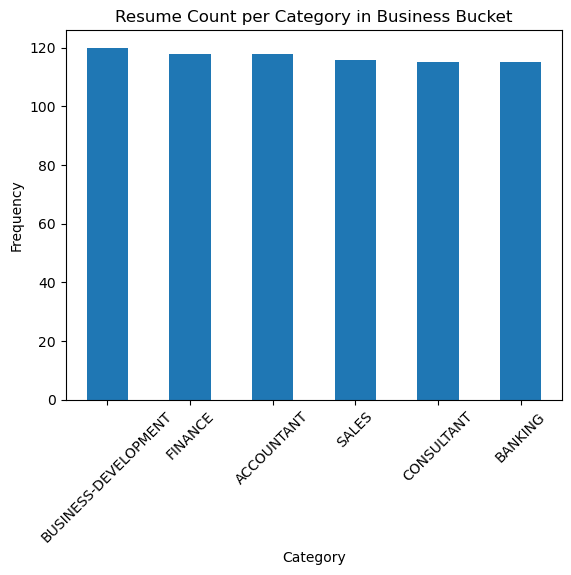

In [16]:
!pip install -q wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

bus_count = df_bus_fin['Category'].value_counts()
bus_count.plot(kind='bar')

plt.title("Resume Count per Category in Business Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

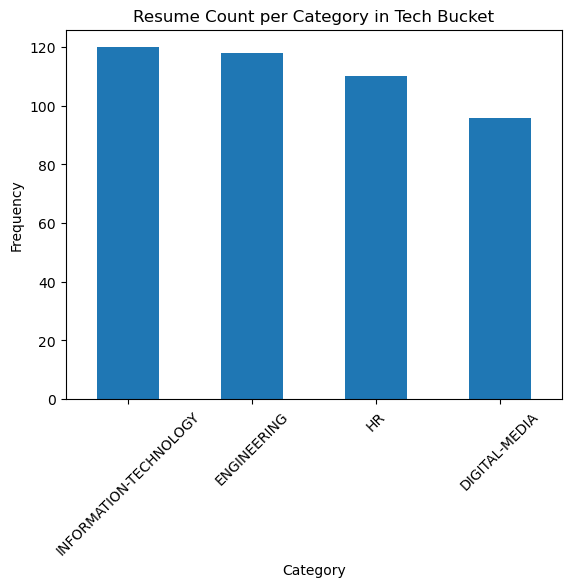

In [17]:
tech_count = df_tech['Category'].value_counts()
tech_count.plot(kind='bar')
plt.title("Resume Count per Category in Tech Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

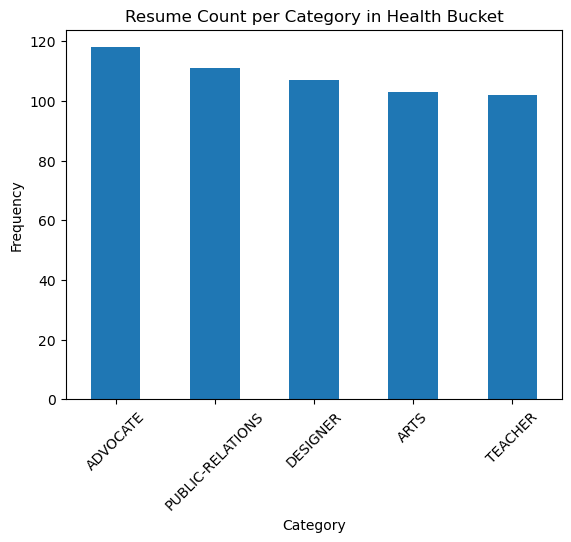

In [18]:
creative_count = df_creative_public['Category'].value_counts()
creative_count.plot(kind='bar')
plt.title("Resume Count per Category in Health Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

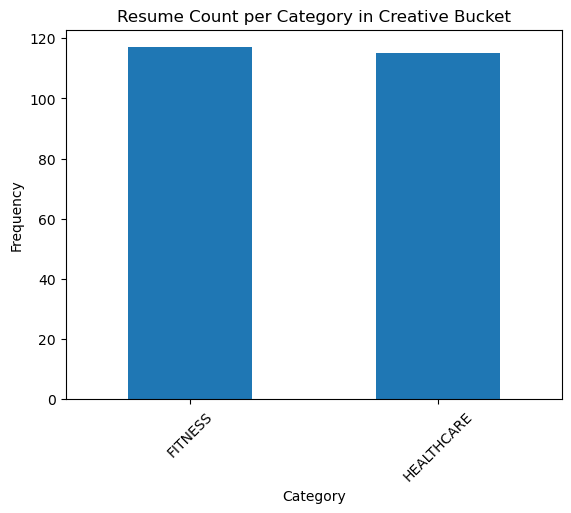

In [19]:
health_count = df_health_well['Category'].value_counts()
health_count.plot(kind='bar')
plt.title("Resume Count per Category in Creative Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

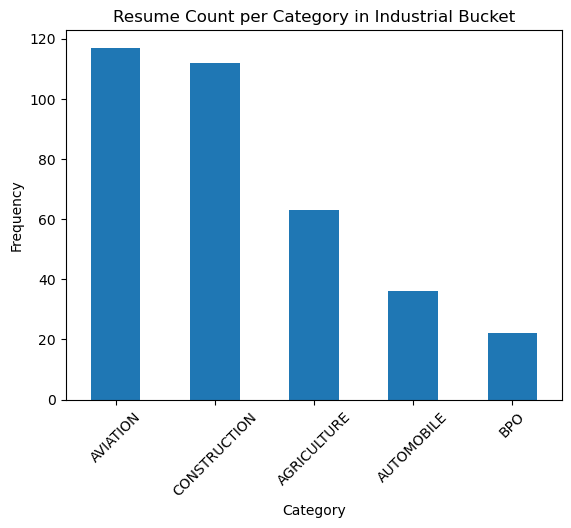

In [20]:
industrial_count = df_indust['Category'].value_counts()
industrial_count.plot(kind='bar')
plt.title("Resume Count per Category in Industrial Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

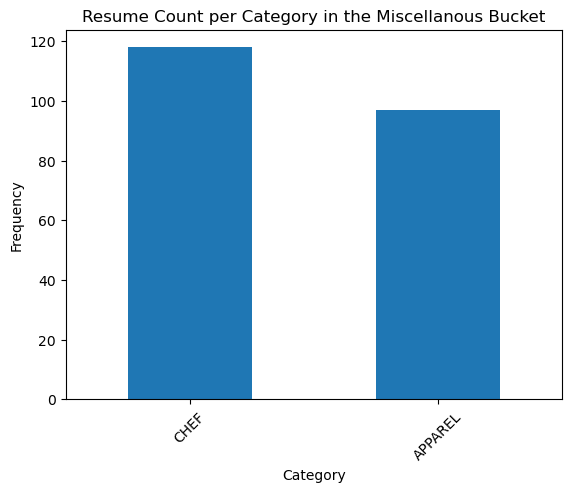

In [21]:
industrial_count = df_misc['Category'].value_counts()
industrial_count.plot(kind='bar')
plt.title("Resume Count per Category in the Miscellanous Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

Index(['ID', 'Resume_str', 'Category', 'Cleaned_str'], dtype='object')
Index(['ID', 'Resume_str', 'Category', 'Cleaned_str'], dtype='object')
Index(['ID', 'Resume_str', 'Category', 'Cleaned_str'], dtype='object')


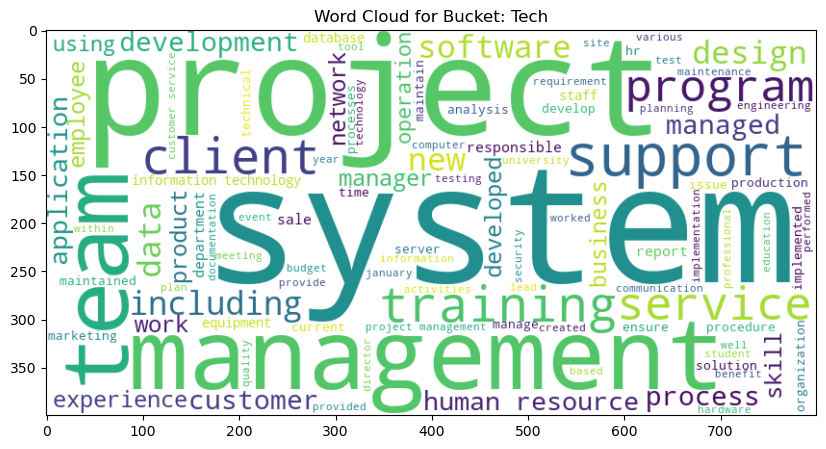

In [22]:
from collections import Counter
print(df_tech.columns)
print(df_bus_fin.columns)
print(df_health_well.columns)

texts = ' '.join(df_tech["Cleaned_str"].astype(str))

custom_stopwords = {'name', 'city', 'state', 'company', 'employee', 'skill'}
words = texts.split()

filtered_words = [word for word in words if word not in custom_stopwords]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Bucket: Tech")
plt.show()

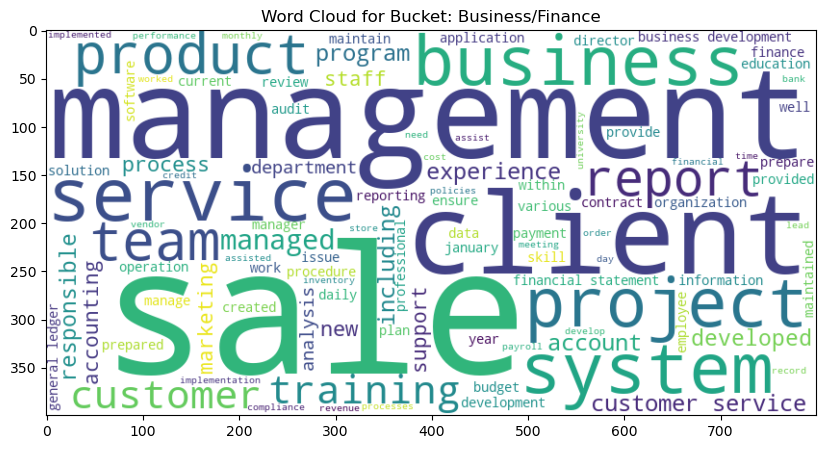

In [23]:
texts = ' '.join(df_bus_fin["Cleaned_str"].astype(str))

custom_stopwords = {'name', 'city', 'state', 'company', 'employee', 'skill', 'City'}
words = texts.split()

filtered_words = [word for word in words if word not in custom_stopwords]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Bucket: Business/Finance")
plt.show()

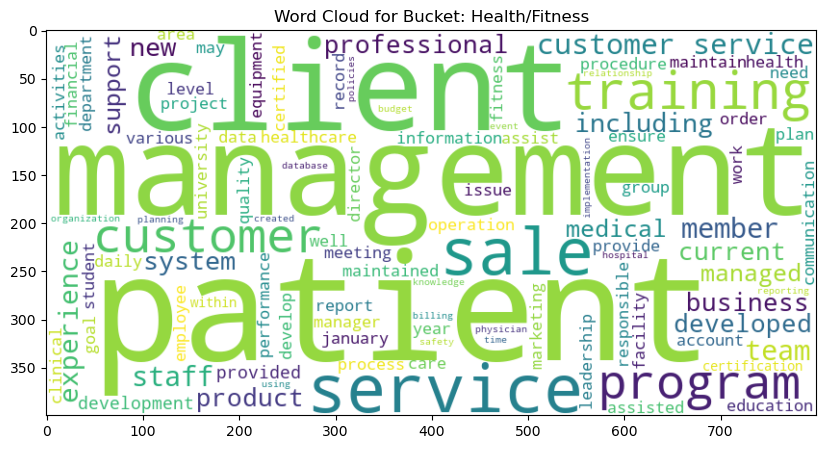

In [43]:
texts = ' '.join(df_health_well["Cleaned_str"].astype(str))

custom_stopwords = {'name', 'city', 'state', 'company', 'employee', 'skill', 'skills'}
words = texts.split()

filtered_words = [word for word in words if word not in custom_stopwords]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Bucket: Health/Fitness")
plt.show()

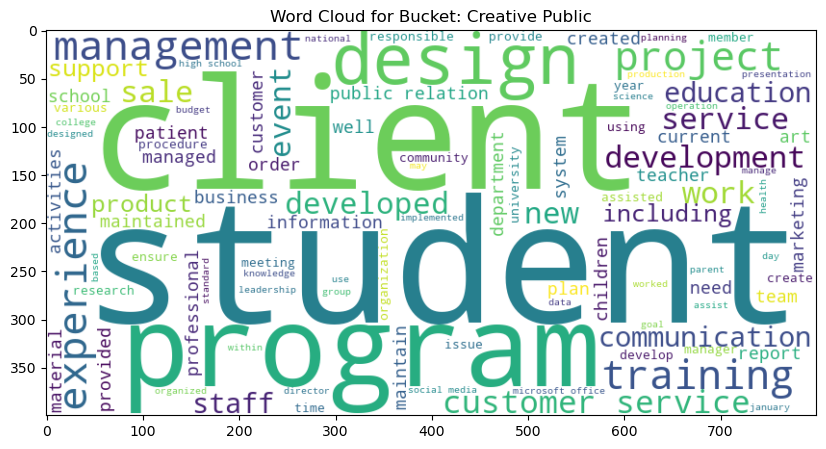

In [39]:
texts = ' '.join(df_creative_public["Cleaned_str"].astype(str))

custom_stopwords = {'name', 'city', 'state', 'company', 'employee', 'skill', 'skills'}
words = texts.split()

filtered_words = [word for word in words if word not in custom_stopwords]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Bucket: Creative Public")
plt.show()

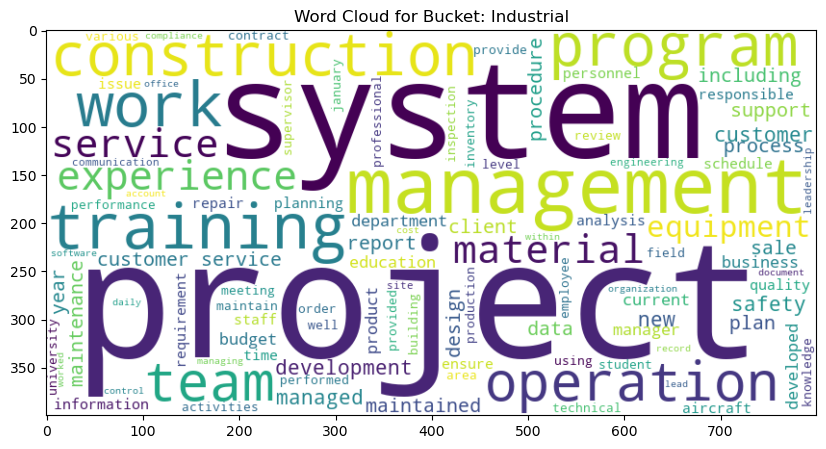

In [41]:
texts = ' '.join(df_indust["Cleaned_str"].astype(str))

custom_stopwords = {'name', 'city', 'state', 'company', 'employee', 'skill', 'skills'}
words = texts.split()

filtered_words = [word for word in words if word not in custom_stopwords]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Bucket: Industrial")
plt.show()

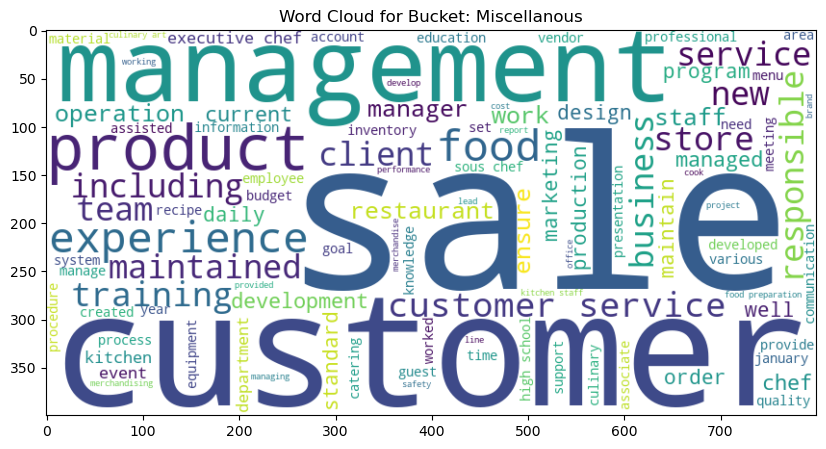

In [35]:
texts = ' '.join(df_misc["Cleaned_str"].astype(str))

custom_stopwords = {'name', 'city', 'state', 'company', 'employee', 'skill', 'skills'}
words = texts.split()

filtered_words = [word for word in words if word not in custom_stopwords]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Bucket: Miscellanous")
plt.show()

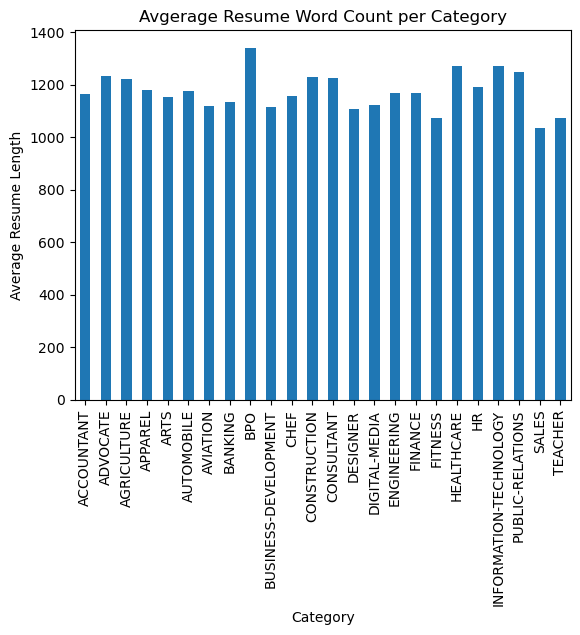

In [45]:
df_orig['resume_length'] = df_orig['Resume_str'].str.count(' ').add(1)
average_length = df_orig.groupby('Category')['resume_length'].mean()

average_length.plot(kind='bar')
plt.title("Avgerage Resume Word Count per Category")
plt.xlabel("Category")
plt.ylabel("Average Resume Length")
plt.xticks(rotation=90)
plt.show()

# Tesla Software and Energy Engineer
## 1. First Resume Cleaning Cycle

In [ ]:
# Extracting related fields from job description

# Move to file potentially
# https://www.linkedin.com/jobs/view/4239183377
tesla_job_desc = (
    "Develop, enhance and debug new and existing real-time software in C/C++ in embedded RTOS environments. "
    "Work with HW and system teams on building testing infrastructure. Help design and bring up state of the art HIL/SIL validation infrastructure. "
    "Help implement software tests for HIL/SIL infrastructure. Assist in tool development for testing and system integration. "
    "Own implementation of software/firmware features end to end. What You'll Bring "
    "Pursuing a Degree in Computer Science, Electrical Engineering, Physics or related field. "
    "Desired to have strong understanding of Python debug simple circuits. "
    "Desired to have good electrical and electronics fundamentals to be able to understand schematics and desired to have test driven development mindset. "
    "Remain engaged, proactive and positive while solving very challenging problems. "
    "Own assignments and take full accountability for overall team success. "
    "Capable of delivering top quality C/C++ code for embedded systems."
)

# Grab fields using regex and the tagline "Pursuing a Degree in...". The RegEx captures everything up to the period and groups it into Group 1.
degree_requirements = re.search(r"Pursuing a Degree in (.+?)(?:\.|$)", tesla_job_desc, re.IGNORECASE)

# We assume (because we are picking the Job Descriptions) that they all have some form of requirements
# Thus, now we can compare each resume in the dataframe and check if they are pursuing a degree in the xyz field.

# Split on commas, and's or or's
degree_fields = re.split(r',\s*| and | or ', degree_requirements.group(1))

# More processing on the actual degrees
degree_fields = [i.strip().lower() for i in degree_fields]
degree_fields.remove("related field")

print("Extracted fields:", degree_fields)

In [ ]:
# Additionally, we need to remove the 'related fields' tag in the split and also replace it with potential related fields
related_fields = ['software engineering', 'computer engineering', 'mechanical engineering', 'data science', 'robotics', 'information technology', 'applied physics']
degree_fields = degree_fields + related_fields
print("Extracted fields:", degree_fields)

In [ ]:
# Now we check if the actual resumes have any variation of these fields in them
def resume_degree_matching(resume):
    for degree in degree_fields:
        if degree in resume:
            return True
    return False

df_tech['matching_degree'] = df_tech['Cleaned_str'].apply(resume_degree_matching)
df_tech_match = df_tech[df_tech['matching_degree'] == True].copy()

In [ ]:
# Load a pre-trained SBERT model (https://sbert.net/)
m_SBERT = SentenceTransformer('all-MiniLM-L6-v2')

results = []

def compute_similarity(index):
    resume = df_tech_match.iloc[index]["Cleaned_str"]
    embed_resume = m_SBERT.encode(resume)
    embed_jobdesc = m_SBERT.encode(tesla_job_desc)
    similarity = cosine_similarity([embed_resume], [embed_jobdesc])[0][0]
    results.append((index, similarity))

for i in range(len(df_tech_match)):
    compute_similarity(i)

In [ ]:
# If over a similarity threshold, print index and similarity.
for i in range(len(results)):
    if results[i][1] > 0.5:
        print(results[i])

## 2. Second Resume Cleaning Cycle

In [ ]:
# Using TF-IDF and cosine similarity to rank the resumes based on the ideal resume 

## 3. Third Resume Cleaning Cycle & SVM Training

In [ ]:
# Train SVM on synthetic lables